C:\Users\ysnrfd\AppData\Local\Temp\ipykernel_8332\1885705929.py:261: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, interval=50)


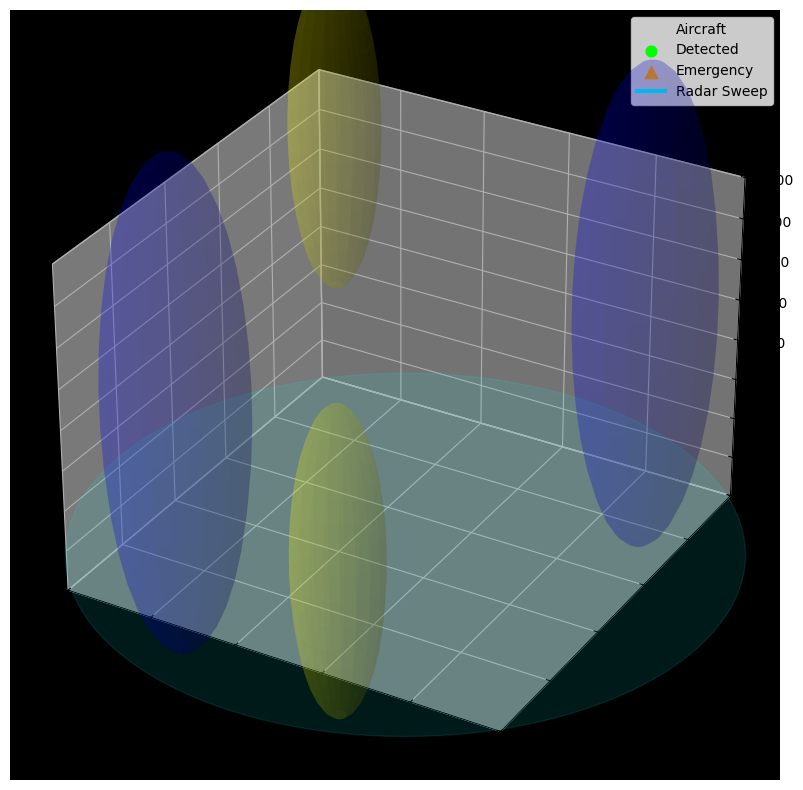

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D, art3d
import random

# Parameters
WORLD_SIZE = 100000
AIRCRAFT_COUNT = 100
RADAR_RANGE = 70000
RADAR_ALTITUDE_LIMIT = 20000  # max altitude radar covers in meters
SCAN_SPEED = 2.0  # degrees per frame
BEAM_WIDTH = 5.0  # degrees width of radar beam
TRACK_LENGTH = 20  # length of tail/track for aircrafts
MAX_ACCELERATION = 5  # m/s^2 max change in velocity per frame
random.
# Aircraft types with properties
AIRCRAFT_TYPES = {
    'commercial': {'rcs_range': (10, 20), 'color': 'cyan', 'size': 30},
    'military': {'rcs_range': (5, 12), 'color': 'red', 'size': 40},
    'drone': {'rcs_range': (1, 4), 'color': 'yellow', 'size': 20},
    'unknown': {'rcs_range': (0.5, 2), 'color': 'magenta', 'size': 25}
}

# Event Class with motion
class MovingEvent3D:
    def __init__(self, evt_type, center, radius, altitude, velocity):
        self.type = evt_type
        self.center = np.array(center, dtype=float)
        self.radius = radius
        self.altitude = altitude
        self.velocity = np.array(velocity, dtype=float)
        self.active = True
    
    def update(self):
        self.center += self.velocity
        # Bounce inside world bounds for x,y
        for i in [0, 1]:
            if self.center[i] < 0 or self.center[i] > WORLD_SIZE:
                self.velocity[i] = -self.velocity[i]
                self.center[i] = np.clip(self.center[i], 0, WORLD_SIZE)
        # Bounce altitude inside radar altitude limit
        if self.altitude < 0 or self.altitude > RADAR_ALTITUDE_LIMIT:
            self.velocity[2] = -self.velocity[2]
            self.altitude = np.clip(self.altitude, 0, RADAR_ALTITUDE_LIMIT)
        # Random on/off toggle for event activity
        if random.random() < 0.001:
            self.active = not self.active

def generate_moving_events_3d():
    events = []
    for _ in range(4):
        evt_type = random.choice(['storm', 'no-fly-zone', 'jamming', 'interference'])
        center = np.random.uniform(0, WORLD_SIZE, 2)
        altitude = np.random.uniform(0, RADAR_ALTITUDE_LIMIT)
        radius = {'storm': 15000, 'no-fly-zone': 10000, 'jamming': 8000, 'interference':12000}[evt_type]
        velocity = np.random.uniform(-50, 50, 3)
        events.append(MovingEvent3D(evt_type, center, radius, altitude, velocity))
    return events

world_events = generate_moving_events_3d()

# Generate aircrafts with altitude, track history, type and variable velocity
def generate_aircraft_3d():
    aircrafts = []
    for i in range(AIRCRAFT_COUNT):
        ac_type = random.choices(list(AIRCRAFT_TYPES.keys()), weights=[0.5,0.3,0.15,0.05])[0]
        rcs_min, rcs_max = AIRCRAFT_TYPES[ac_type]['rcs_range']
        ac = {
            'id': i,
            'type': ac_type,
            'position': np.array([*np.random.uniform(0, WORLD_SIZE, 2), np.random.uniform(0, RADAR_ALTITUDE_LIMIT)]),
            'velocity': np.random.uniform(-50, 50, 3),
            'rcs': random.uniform(rcs_min, rcs_max),
            'callsign': f"{ac_type[:2].upper()}{i:03}",
            'emergency': random.random() < 0.03,
            'track': [],
            'acceleration': np.zeros(3),
        }
        aircrafts.append(ac)
    return aircrafts

aircrafts = generate_aircraft_3d()
radar_angle = [0]
radar_pos = np.array([WORLD_SIZE/2, WORLD_SIZE/2, 0])
paused = [False]

def is_event_active_3d(pos):
    for evt in world_events:
        if evt.active:
            d_xy = np.linalg.norm(pos[:2] - evt.center)
            dz = abs(pos[2] - evt.altitude)
            if d_xy < evt.radius and dz < evt.radius / 2:
                return evt.type
    return None

def detect_3d(ac, radar_pos):
    delta = ac['position'] - radar_pos
    rng = np.linalg.norm(delta)
    if rng > RADAR_RANGE or ac['position'][2] > RADAR_ALTITUDE_LIMIT:
        return False
    bearing = (np.degrees(np.arctan2(delta[1], delta[0])) + 360) % 360
    diff = abs((bearing - radar_angle[0] + 180) % 360 - 180)
    if diff > BEAM_WIDTH / 2:
        return False
    evt = is_event_active_3d(ac['position'])
    snr_val = 20 - 20*np.log10(rng + 1) + ac['rcs']
    if evt == 'jamming':
        snr_val -= 50
    elif evt == 'storm':
        snr_val -= 15
    elif evt == 'interference':
        snr_val -= 25
    prob = 1 / (1 + np.exp(-(snr_val - 10)))
    # Introduce random detection noise
    noise = np.random.normal(0, 0.1)
    return np.random.rand() < (prob + noise)

# Setup plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(0, WORLD_SIZE)
ax.set_ylim(0, WORLD_SIZE)
ax.set_zlim(0, RADAR_ALTITUDE_LIMIT)
ax.set_facecolor('black')

# Scatter for different types of aircrafts (dynamic update)
all_scatter = ax.scatter([], [], [], c=[], s=[], label='Aircraft')
detected_scatter = ax.scatter([], [], [], c='lime', s=60, label='Detected')
emergency_scatter = ax.scatter([], [], [], c='orange', s=80, marker='^', label='Emergency')
radar_sweep_line, = ax.plot([], [], [], c='cyan', linewidth=3, label='Radar Sweep')

# Track lines for aircrafts
track_lines = [ax.plot([], [], [], c='white', alpha=0.3, linewidth=1)[0] for _ in range(AIRCRAFT_COUNT)]

event_spheres = []
event_colors = {'storm':'blue', 'no-fly-zone':'yellow', 'jamming':'magenta', 'interference':'purple'}

def plot_sphere(center, radius, color):
    u = np.linspace(0, 2*np.pi, 20)
    v = np.linspace(0, np.pi, 20)
    x = center[0] + radius * np.outer(np.cos(u), np.sin(v))
    y = center[1] + radius * np.outer(np.sin(u), np.sin(v))
    z = center[2] + radius * np.outer(np.ones(np.size(u)), np.cos(v))
    return ax.plot_surface(x, y, z, color=color, alpha=0.15)

for evt in world_events:
    sphere = plot_sphere(np.array([*evt.center, evt.altitude]), evt.radius, event_colors[evt.type])
    event_spheres.append(sphere)

# Radar range circle on ground
radar_circle = plt.Circle((radar_pos[0], radar_pos[1]), RADAR_RANGE, color='cyan', alpha=0.1)
ax.add_patch(radar_circle)
art3d.pathpatch_2d_to_3d(radar_circle, z=0, zdir="z")

def update(frame):
    if paused[0]:
        return
    
    # به‌روزرسانی زاویه رادار
    radar_angle[0] = (radar_angle[0] + 1) % 360

    all_pos = []
    all_colors = []
    all_sizes = []

    detected_pos = []
    emergency_pos = []

    for ac in aircrafts:
        # محدود کردن سرعت
        v_mag = np.linalg.norm(ac['velocity'])
        max_speed = 250  # m/s
        if v_mag > max_speed:
            ac['velocity'] = (ac['velocity'] / v_mag) * max_speed
        
        # به‌روزرسانی موقعیت
        ac['position'] += ac['velocity']
        
        # برخورد به دیواره‌های جهان
        for i in [0, 1]:
            if ac['position'][i] < 0 or ac['position'][i] > WORLD_SIZE:
                ac['velocity'][i] = -ac['velocity'][i]
                ac['position'][i] = np.clip(ac['position'][i], 0, WORLD_SIZE)
        if ac['position'][2] < 0 or ac['position'][2] > RADAR_ALTITUDE_LIMIT:
            ac['velocity'][2] = -ac['velocity'][2]
            ac['position'][2] = np.clip(ac['position'][2], 0, RADAR_ALTITUDE_LIMIT)
        
        # ثبت رد حرکت
        ac['track'].append(ac['position'].copy())
        if len(ac['track']) > TRACK_LENGTH:
            ac['track'].pop(0)
        
        all_pos.append(ac['position'])
        all_colors.append(AIRCRAFT_TYPES[ac['type']]['color'])
        all_sizes.append(AIRCRAFT_TYPES[ac['type']]['size'])
        
        if detect_3d(ac, radar_pos):
            detected_pos.append(ac['position'])
            if ac['emergency']:
                emergency_pos.append(ac['position'])

    # تبدیل به np.array
    all_pos = np.array(all_pos)
    detected_pos = np.array(detected_pos)
    emergency_pos = np.array(emergency_pos)

    # آپدیت scatter کل هواپیماها
    if len(all_pos) > 0:
        all_scatter._offsets3d = (all_pos[:,0], all_pos[:,1], all_pos[:,2])
        all_scatter.set_color(all_colors)
        all_scatter.set_sizes(all_sizes)
    else:
        all_scatter._offsets3d = ([], [], [])
        all_scatter.set_color([])
        all_scatter.set_sizes([])

    # آپدیت scatter هواپیماهای تشخیص داده شده
    if len(detected_pos) > 0:
        detected_scatter._offsets3d = (detected_pos[:,0], detected_pos[:,1], detected_pos[:,2])
        detected_scatter.set_sizes([60]*len(detected_pos))
    else:
        detected_scatter._offsets3d = ([], [], [])
        detected_scatter.set_sizes([])

    # آپدیت scatter هواپیماهای اضطراری
    if len(emergency_pos) > 0:
        emergency_scatter._offsets3d = (emergency_pos[:,0], emergency_pos[:,1], emergency_pos[:,2])
        emergency_scatter.set_sizes([80]*len(emergency_pos))
    else:
        emergency_scatter._offsets3d = ([], [], [])
        emergency_scatter.set_sizes([])

    # به‌روزرسانی خطوط رد حرکت
    for i, ac in enumerate(aircrafts):
        if len(ac['track']) >= 2:
            track_arr = np.array(ac['track'])
            track_lines[i].set_data(track_arr[:,0], track_arr[:,1])
            track_lines[i].set_3d_properties(track_arr[:,2])
        else:
            track_lines[i].set_data([], [])
            track_lines[i].set_3d_properties([])

    # به‌روزرسانی خط اسکن رادار
    angle_rad = np.radians(radar_angle[0])
    x = [radar_pos[0], radar_pos[0] + RADAR_RANGE * np.cos(angle_rad)]
    y = [radar_pos[1], radar_pos[1] + RADAR_RANGE * np.sin(angle_rad)]
    z = [0, 0]
    radar_sweep_line.set_data(x, y)
    radar_sweep_line.set_3d_properties(z)

    ax.set_title(f"3D Radar Simulation - Scan Angle: {radar_angle[0]:.1f}°")
    
def on_key(event):
    if event.key == ' ':
        paused[0] = not paused[0]

fig.canvas.mpl_connect('key_press_event', on_key)

ani = FuncAnimation(fig, update, interval=50)
plt.legend(loc='upper right')
plt.show()
